# Intro

@Date: 15.9.16 <br>
@Author: Tal Peretz<br>
@TL;DR: The goal of this notebook is to extract trend features describing the zik engine 

# Imports

In [127]:
import pandas as pd
import numpy as np
import pickle
import random
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa
import os
import subprocess
import datetime
%matplotlib inline

# TS Data Generation

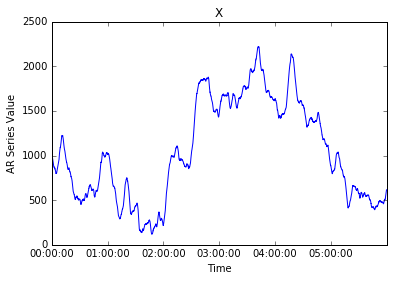

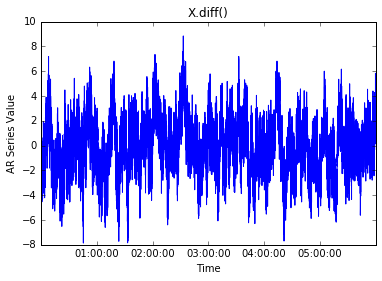

In [231]:
# ensures experiment runs the same every time
np.random.seed(45)

# This function simluates an AR process, generating a new value based on historial values,
# autoregressive coefficients b1 ... bk, and some randomness.
def AR(b, X, mu, sigma):
    l = min(len(b)-1, len(X))
    b0 = b[0]
    
    return b0 + np.dot(b[1:l+1], X[-l:]) + np.random.normal(mu, sigma)


def simululate_AR_process(b, T):
    X = np.array([1])

    mu = 0
    sigma = 1

    for i in range(T):
        X = np.append(X, AR(b, X, mu, sigma))
        
    return X

Z = simululate_AR_process(np.array([0, 0.8, 0.1, 0.05]), 6*60*30-1)
# Build X so it wouldn't be stationary but X.diff() would be stationary
date_idxs = pd.date_range('24/5/1992', periods=6*60*30, freq=datetime.timedelta(seconds=2))
X = pd.Series(Z.cumsum() + 1000, index=date_idxs)
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(X)
plt.title('X')
plt.xlabel('Time')
plt.ylabel('AR Series Value');

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(X.diff())
plt.title('X.diff()')
plt.xlabel('Time')
plt.ylabel('AR Series Value');

X.to_csv('S:\\Data_Mining\\Theory\\F15_flight_engine_temp.csv')

# Stationarity

The trick here is to change the series - instead of looking at the given temp, we need to us the change since last temp (diff) <br>
the correct solution would include the transformation of the series to a stationary series

In [190]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 

C:\Anaconda2 4.1.1\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Anaconda2 4.1.1\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


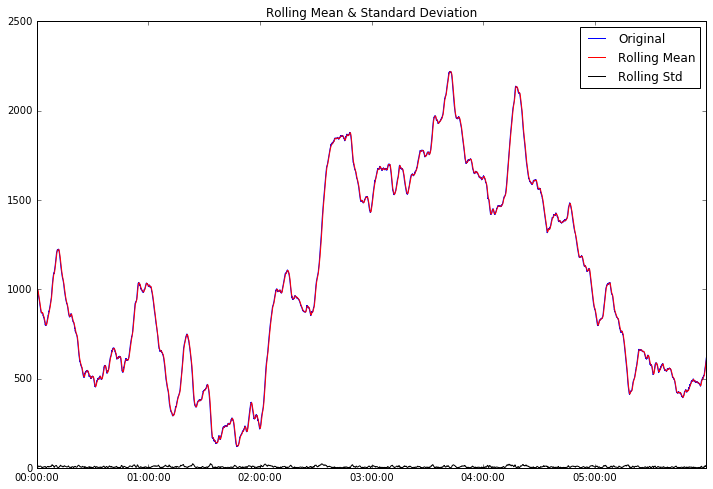

Results of Dickey-Fuller Test:
Test Statistic                    -1.913026
p-value                            0.325958
#Lags Used                         3.000000
Number of Observations Used    10796.000000
Critical Value (5%)               -2.861808
Critical Value (1%)               -3.430956
Critical Value (10%)              -2.566913
dtype: float64


In [191]:
test_stationarity(X)

p_value > 0.01    /     Test_Statistic > Critical_Value(0.01)      =>     the series is likely not stationary

# Transformation

### Differencing

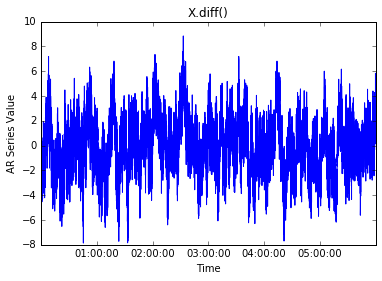

In [192]:
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(X.diff())
plt.title('X.diff()')
plt.xlabel('Time')
plt.ylabel('AR Series Value');

C:\Anaconda2 4.1.1\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Anaconda2 4.1.1\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


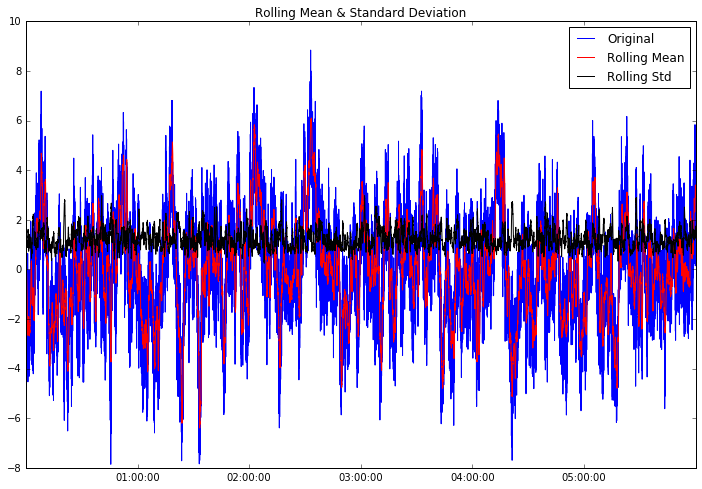

Results of Dickey-Fuller Test:
Test Statistic                -9.699926e+00
p-value                        1.079022e-16
#Lags Used                     2.000000e+00
Number of Observations Used    1.079600e+04
Critical Value (5%)           -2.861808e+00
Critical Value (1%)           -3.430956e+00
Critical Value (10%)          -2.566913e+00
dtype: float64


In [193]:
test_stationarity(X.diff()[1:])

p_value < 0.01    /     Test_Statistic < Critical_Value(0.01)      =>     the series is likely stationary

### Decomposing

Notice that in order to use seasonal decompose you need to change freq to 24 - it's a bug in statsmodel

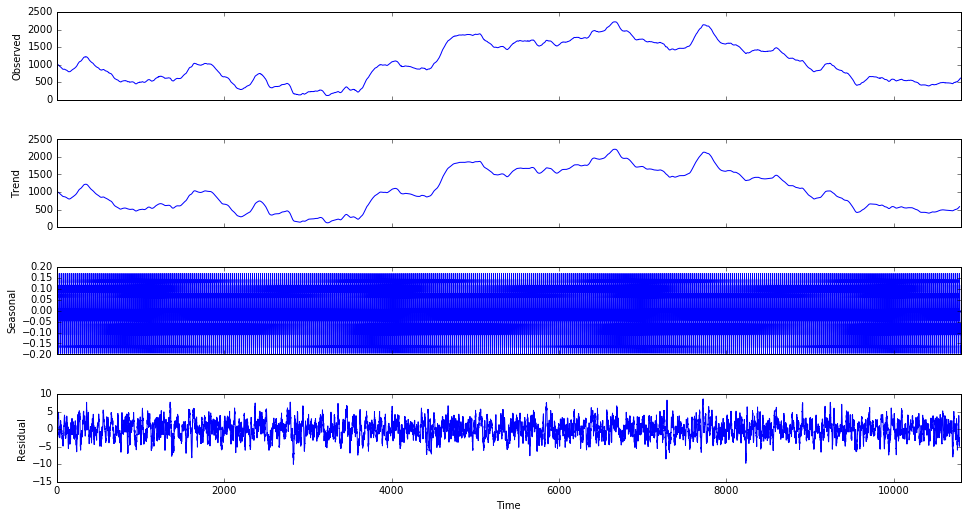

In [194]:
decomposition = sm.tsa.seasonal_decompose(X.values, freq=24)
fig = plt.figure()
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

C:\Anaconda2 4.1.1\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Anaconda2 4.1.1\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


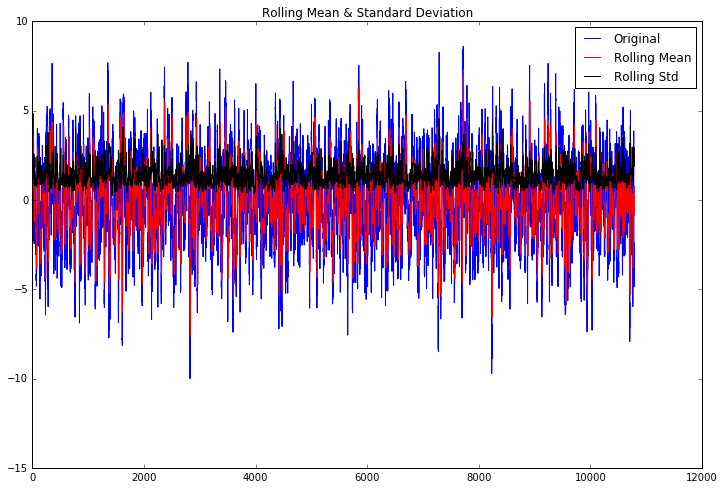

Results of Dickey-Fuller Test:
Test Statistic                   -20.050292
p-value                            0.000000
#Lags Used                        28.000000
Number of Observations Used    10747.000000
Critical Value (5%)               -2.861809
Critical Value (1%)               -3.430959
Critical Value (10%)              -2.566913
dtype: float64


In [195]:
X_residuals = pd.Series(decomposition.resid)
X_residuals.dropna(inplace=True)
test_stationarity(X_residuals)

p_value < 0.01    /     Test_Statistic < Critical_Value(0.01)      =>     the series is likely stationary

We chose diff cause it's easier and still stationary 

In [196]:
X = X.diff()[1:]

# ACF, PACF

again, we want to continue with the stationary series that wev'e build instead of the original series

In [197]:
from statsmodels.tsa.stattools import acf, pacf

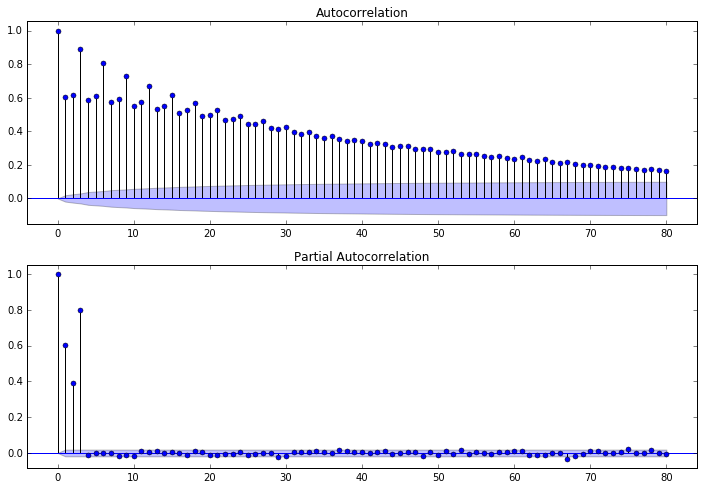

In [198]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X, lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X, lags=80, ax=ax2)

### choosing num of parameters

In [199]:
N = 10
AIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.api.AR(X)
    model = model.fit(maxlag=(i+1))
    AIC[i] = model.aic
    
AIC_min = np.min(AIC)
model_min = np.argmin(AIC)

print 'Relative Likelihoods'
print np.exp((AIC_min-AIC) / 2)
print 'Number of parameters in minimum AIC model %s' % (model_min+1)

Relative Likelihoods
[[ 0.55028477]
 [ 0.59829668]
 [ 0.99999443]
 [ 0.99988898]
 [ 0.99982631]
 [ 1.        ]
 [ 0.99986889]
 [ 0.99993065]
 [ 0.99985632]
 [ 0.99992763]]
Number of parameters in minimum AIC model 6


In [200]:
N = 10
BIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.api.AR(X)
    model = model.fit(maxlag=(i+1))
    BIC[i] = model.bic
    
BIC_min = np.min(BIC)
model_min = np.argmin(BIC)

print 'Relative Likelihoods'
print np.exp((BIC_min-BIC) / 2)
print 'Number of parameters in minimum BIC model %s' % (model_min+1)

Relative Likelihoods
[[ 0.55065947]
 [ 0.59850202]
 [ 1.        ]
 [ 0.999557  ]
 [ 0.99915688]
 [ 0.99899298]
 [ 0.99852464]
 [ 0.99824899]
 [ 0.99783754]
 [ 0.9975715 ]]
Number of parameters in minimum BIC model 3


### Evaluating Residuals

In [201]:
model = tsa.api.AR(X)
model = model.fit(maxlag=3)

from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(model.resid)

if pvalue < 0.1:
    print 'We have reason to suspect the residuals are not normally distributed.'
else:
    print 'The residuals seem normally distributed.'

The residuals seem normally distributed.


#### ARIMA Params

In [202]:
p, q, d = 3, 3, 0

# AR Model

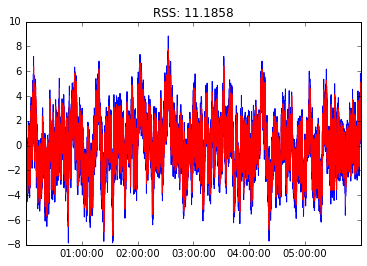

In [211]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(X, order=(p, d, q))
results_ARIMA = model.fit(disp=-1)
plt.plot(X)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% ((sum(results_ARIMA.fittedvalues-X))**2))

# Original Scale

In [212]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

1992-05-24 00:00:02   -0.020332
1992-05-24 00:00:04    0.490505
1992-05-24 00:00:06    0.738377
1992-05-24 00:00:08    0.802537
1992-05-24 00:00:10    0.997998
Freq: 2S, dtype: float64


In [213]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

1992-05-24 00:00:02   -0.020332
1992-05-24 00:00:04    0.470173
1992-05-24 00:00:06    1.208550
1992-05-24 00:00:08    2.011087
1992-05-24 00:00:10    3.009085
Freq: 2S, dtype: float64


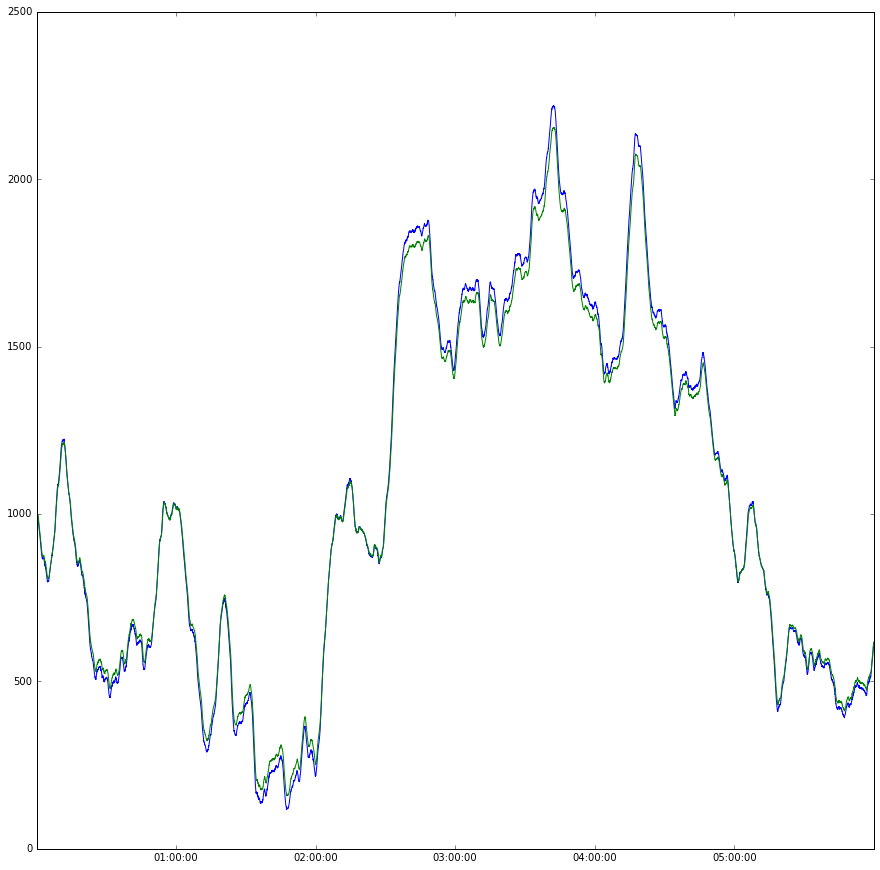

In [219]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
axes.plot(X.cumsum() + 1000)
axes.plot(predictions_ARIMA_diff_cumsum + 1000)

In [220]:
MSE = sum((predictions_ARIMA_diff_cumsum-X.cumsum())**2 / len(X.cumsum()))
RMSE = np.sqrt(MSE)
print RMSE

29.032449511
